This is the original model

# Load data

In [1]:
import os
import argparse
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from keras.models import Sequential, Model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Input
from keras.utils.data_utils import get_file
#from keras.regularizers import WeightRegularizer
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, History
from keras.layers.normalization import BatchNormalization
#from theano.ifelse import ifelse

Using Theano backend.


In [3]:
#name = 'bpi_12_w'
name = 'helpdesk'
args = {
    'inputdir': '../input/{}/'.format(name),   
    'outputdir': './output_files/{}/'.format(name)
}

args = argparse.Namespace(**args)

In [4]:
if not os.path.isdir(args.outputdir):
    os.makedirs(args.outputdir)

In [5]:
with open(args.inputdir + 'parameters.pkl', "rb") as f:
    maxlen = pickle.load(f)
    num_features = pickle.load(f)
    chartoindice = pickle.load(f)
    targetchartoindice = pickle.load(f)
    divisor = pickle.load(f)
    divisor2 = pickle.load(f)

In [6]:
with open(args.inputdir + 'preprocessed_data.pkl', "rb") as f:
    X = pickle.load(f)
    y_a = pickle.load(f)
    y_t = pickle.load(f)
    X_test = pickle.load(f)
    y_a_test = pickle.load(f)
    y_t_test = pickle.load(f)

# Model for activity

In [7]:
# build the model: 
print('Build model...')
main_input = Input(shape=(maxlen, num_features), name='main_input')

# shared layer
l1 = LSTM(100, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True, implementation=2)(main_input)
b1 = BatchNormalization()(l1)

# the layer specialized in activity prediction
l2_1 = LSTM(100, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=False, implementation=2)(b1) 
b2_1 = BatchNormalization()(l2_1)


act_output = Dense(len(targetchartoindice), kernel_initializer="glorot_uniform", name="act_output", activation="softmax")(b2_1)

model = Model(inputs=[main_input], outputs=[act_output])

opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

model.compile(loss={'act_output':'categorical_crossentropy'}, 
              optimizer=opt, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=42)
model_checkpoint = ModelCheckpoint(args.outputdir + 'model_a_{epoch:02d}-{val_loss:.2f}.h5', 
                                   monitor='val_loss', verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, 
                               mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
history_a = History()

model.fit(X, {'act_output':y_a}, validation_split=0.2, verbose=2, 
          callbacks=[early_stopping, model_checkpoint, lr_reducer, history_a], batch_size=maxlen, epochs=500)

Build model...
Train on 7344 samples, validate on 1837 samples
Epoch 1/500
14s - loss: 0.9908 - acc: 0.7102 - val_loss: 0.6993 - val_acc: 0.8062
Epoch 2/500
12s - loss: 0.7195 - acc: 0.7704 - val_loss: 0.5973 - val_acc: 0.8198
Epoch 3/500
12s - loss: 0.6887 - acc: 0.7806 - val_loss: 0.5992 - val_acc: 0.8176
Epoch 4/500
12s - loss: 0.6809 - acc: 0.7861 - val_loss: 0.5946 - val_acc: 0.8231
Epoch 5/500
12s - loss: 0.6635 - acc: 0.7923 - val_loss: 0.5737 - val_acc: 0.8274
Epoch 6/500
12s - loss: 0.6692 - acc: 0.7847 - val_loss: 0.5727 - val_acc: 0.8242
Epoch 7/500
12s - loss: 0.6579 - acc: 0.7923 - val_loss: 0.5866 - val_acc: 0.8236
Epoch 8/500
12s - loss: 0.6577 - acc: 0.7904 - val_loss: 0.5815 - val_acc: 0.8247
Epoch 9/500
12s - loss: 0.6492 - acc: 0.7953 - val_loss: 0.5675 - val_acc: 0.8253
Epoch 10/500
13s - loss: 0.6534 - acc: 0.7883 - val_loss: 0.5608 - val_acc: 0.8291
Epoch 11/500
12s - loss: 0.6450 - acc: 0.7985 - val_loss: 0.5608 - val_acc: 0.8280
Epoch 12/500
13s - loss: 0.6513 -

# Model for time

In [8]:
# build the model: 
print('Build model...')
main_input = Input(shape=(maxlen, num_features), name='main_input')

# shared layer
l1 = LSTM(100, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=True, implementation=2)(main_input) 
b1 = BatchNormalization()(l1)

# the layer specialized in time prediction
l2_2 = LSTM(100, kernel_initializer="glorot_uniform", dropout=0.2, return_sequences=False, implementation=2)(b1) 
b2_2 = BatchNormalization()(l2_2)

time_output = Dense(1, kernel_initializer="glorot_uniform", name="time_output")(b2_2)

model = Model(inputs=[main_input], outputs=[time_output])

opt = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004, clipvalue=3)

model.compile(loss={'time_output':'mae'}, optimizer=opt)
early_stopping = EarlyStopping(monitor='val_loss', patience=42)
model_checkpoint = ModelCheckpoint(args.outputdir + 'model_t_{epoch:02d}-{val_loss:.2f}.h5', 
                                   monitor='val_loss', verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto')
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=0, 
                               mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
history_t = History()

model.fit(X, {'time_output':y_t}, validation_split=0.2, verbose=2, 
          callbacks=[early_stopping, model_checkpoint, lr_reducer, history_t], batch_size=maxlen, epochs=500)

Build model...
Train on 7344 samples, validate on 1837 samples
Epoch 1/500
11s - loss: 1.2023 - val_loss: 1.0516
Epoch 2/500
12s - loss: 1.0575 - val_loss: 1.0152
Epoch 3/500
12s - loss: 1.0314 - val_loss: 0.9888
Epoch 4/500
13s - loss: 1.0191 - val_loss: 0.9705
Epoch 5/500
12s - loss: 1.0119 - val_loss: 0.9837
Epoch 6/500
12s - loss: 1.0055 - val_loss: 0.9724
Epoch 7/500
12s - loss: 1.0060 - val_loss: 0.9867
Epoch 8/500
12s - loss: 1.0082 - val_loss: 0.9693
Epoch 9/500
12s - loss: 1.0051 - val_loss: 0.9763
Epoch 10/500
12s - loss: 0.9978 - val_loss: 0.9575
Epoch 11/500
12s - loss: 0.9965 - val_loss: 0.9802
Epoch 12/500
12s - loss: 0.9974 - val_loss: 0.9598
Epoch 13/500
12s - loss: 0.9980 - val_loss: 0.9651
Epoch 14/500
12s - loss: 0.9977 - val_loss: 0.9731
Epoch 15/500
13s - loss: 0.9911 - val_loss: 0.9561
Epoch 16/500
12s - loss: 0.9949 - val_loss: 0.9653
Epoch 17/500
12s - loss: 0.9937 - val_loss: 0.9545
Epoch 18/500
12s - loss: 0.9973 - val_loss: 0.9712
Epoch 19/500
12s - loss: 0.9

In [9]:
history_a.history.keys()

dict_keys(['acc', 'loss', 'val_loss', 'lr', 'val_acc'])

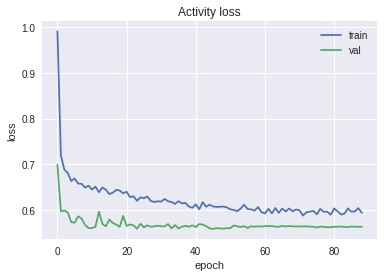

In [10]:
# summarize history for activity accuracy
plt.plot(history_a.history['loss'])
plt.plot(history_a.history['val_loss'])
plt.title('Activity loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

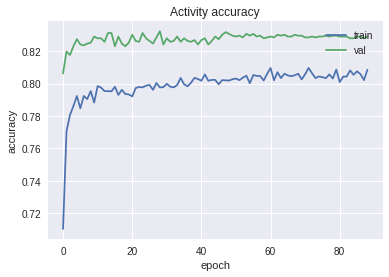

In [11]:
# summarize history for activity accuracy
plt.plot(history_a.history['acc'])
plt.plot(history_a.history['val_acc'])
plt.title('Activity accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

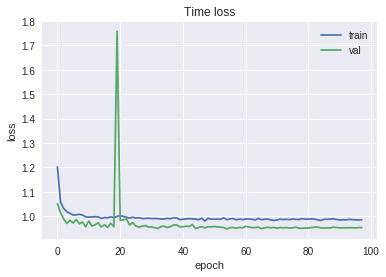

In [12]:
# summarize history for time loss
plt.plot(history_t.history['loss'])
plt.plot(history_t.history['val_loss'])
plt.title('Time loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()